## Library imports

In [1]:
import numpy as np
import pandas as pd
from chromatography import ExperimentAnalytes
from separation_utility import *
from torch import optim, tensor
import matplotlib.pyplot as plt
import time

## Dataset Import

In [2]:
alists = []
alists.append(pd.read_csv(f'../data/GilarSample.csv'))
alists.append(pd.read_csv(f'../data/Alizarin.csv'))
alists.append(pd.read_csv(f'../data/Peterpeptides.csv'))
alists.append(pd.read_csv(f'../data/Roca.csv'))
alists.append(pd.read_csv(f'../data/Peter32.csv'))
alists.append(pd.read_csv(f'../data/Eosin.csv'))
alists.append(pd.read_csv(f'../data/Controlmix2.csv'))
# GilarSample - 8 analytes
# Peterpeptides - 32 analytes
# Roca - 14 analytes
# Peter32 - 32 analytes
# Eosin - 20 analytes
# Alizarin - 16 analytes
# Controlmix2 - 17 analytes
# Gooding - 872 analytes

## Useful functions definition

In [3]:
def loss_field(exp, taus, N = 200):
    phis = np.linspace(0, 1, N)
    losses = np.zeros((N, N))
    j = 0
    for phi1 in phis:
        i = 0
        for phi2 in phis:
            exp.reset()
            exp.run_all([phi1, phi2], taus)
            losses[i, j] = exp.loss()
            i += 1
        j += 1
    X, Y = np.meshgrid(phis, phis)
    
    return X, Y, losses
def average_over_equal_intervals(arr, interval):
    return np.mean(arr.reshape(-1, interval), axis=1)

### Experiment: Performance vs n_steps

In [ ]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}
N = 7
M = 50
# Experiments
exp_8 = ExperimentAnalytes(k0 = alists[0].k0.values, S = alists[0].S.values, h=0.001, run_time=1.0)
exp_16 = ExperimentAnalytes(k0 = alists[1].k0.values, S = alists[1].S.values, h=0.001, run_time=1.0)
exp_32 = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)
# Final Results 
dist_8 = np.zeros((N, M))
dist_16 = np.zeros((N, M))
dist_32 = np.zeros((N, M))

for n in range(0, N):
    print(n)
    delta_taus = np.ones(n + 1) * 1/(n + 1)
    
    for i in range(M):
        print(f"  {i}")
        #Policies
        pol_8 = PolicySingle(len(delta_taus), sigma_max = sigma_max)
        pol_16 = PolicySingle(len(delta_taus), sigma_max = sigma_max)
        pol_32 = PolicySingle(len(delta_taus), sigma_max = sigma_max)
        # Run Exp 8
        reinforce_one_set(
                exp_8, 
                pol_8, 
                delta_taus=delta_taus, 
                **kwargs
            )
        # Run Exp 16
        reinforce_one_set(
                exp_16, 
                pol_16, 
                delta_taus=delta_taus, 
                **kwargs
            )
        # Run Exp 32
        reinforce_one_set(
                exp_32, 
                pol_32, 
                delta_taus=delta_taus, 
                **kwargs
            )
        
        exp_8.reset()
        exp_16.reset()
        exp_32.reset()
        mu_8, _ = pol_8.forward()
        mu_16, _ = pol_16.forward()
        mu_32, _ = pol_32.forward()
        exp_8.run_all(mu_8.detach().numpy(), delta_taus)
        exp_16.run_all(mu_16.detach().numpy(), delta_taus)
        exp_32.run_all(mu_32.detach().numpy(), delta_taus)
        
        dist_8[n, i] = exp_8.loss()
        dist_16[n, i] = exp_16.loss()
        dist_32[n, i] = exp_32.loss()

In [ ]:
np.savez_compressed("../results/distribution_single_perf_vs_n_steps", nr_analytes_8=dist_8, nr_analytes_16=dist_16, nr_analytes_32=dist_32)

### Experiment: RL vs grid search

In [ ]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}
exp = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)

### one n_step
loss = 3.
delta_taus = [1.]
print("Grid Search 1")
# Grid Search
start_gs_1 = time.perf_counter()
for phi in np.linspace(0, 1, 100):
    exp.reset()
    exp.run_all([phi], delta_taus)
    if exp.loss() < loss:
        loss = exp.loss()
        best_1 = [phi]
end_gs_1 = time.perf_counter()
# RL
print("RL 1")
start_rl_1 = time.perf_counter()
for n in range(10):
    pol = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    reinforce_one_set(
            exp, 
            pol, 
            delta_taus=delta_taus, 
            **kwargs
        )
end_rl_1 = time.perf_counter()


### two n_step
loss = 3.
delta_taus = [.5, .5]
# Grid Search
print("Grid Search 2")
start_gs_2 = time.perf_counter()
for phi_1 in np.linspace(0, 1, 100):
    for phi_2 in np.linspace(0, 1, 100):
        exp.reset()
        exp.run_all([phi_1, phi_2], delta_taus)
        if exp.loss() < loss:
            loss = exp.loss()
            best_2 = [phi_1, phi_2]
end_gs_2 = time.perf_counter()
# RL
print("RL 2")
start_rl_2 = time.perf_counter()
for n in range(10):
    pol = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    reinforce_one_set(
            exp, 
            pol, 
            delta_taus=delta_taus, 
            **kwargs
        )
end_rl_2 = time.perf_counter()
### three n_step
loss = 3.
delta_taus = [.33, .33, .34]
# Grid Search
print("Grid Search 3")
start_gs_3 = time.perf_counter()
for phi_1 in np.linspace(0, 1, 100):
    for phi_2 in np.linspace(0, 1, 100):
        for phi_3 in np.linspace(0, 1, 100):
            exp.reset()
            exp.run_all([phi_1, phi_2, phi_3], delta_taus)
            if exp.loss() < loss:
                loss = exp.loss()
                best_3 = [phi_1, phi_2, phi_3]
end_gs_3 = time.perf_counter()
# RL
print("RL 3")
start_rl_3 = time.perf_counter()
for n in range(10):
    pol = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    reinforce_one_set(
            exp, 
            pol, 
            delta_taus=delta_taus, 
            **kwargs
        )
end_rl_3 = time.perf_counter()
### four n_step
loss = 3.
delta_taus = [.25, .25, .25, .25]
# Grid Search
print("Grid Search 4")
start_gs_4 = time.perf_counter()
for phi_1 in np.linspace(0, 1, 100):
    for phi_2 in np.linspace(0, 1, 100):
        for phi_3 in np.linspace(0, 1, 100):
            for phi_4 in np.linspace(0, 1, 100):
                exp.reset()
                exp.run_all([phi_1, phi_2, phi_3, phi_4], delta_taus)
                if exp.loss() < loss:
                    loss = exp.loss()
                    best_4 = [phi_1, phi_2, phi_3, phi_4]
end_gs_4 = time.perf_counter()
# RL
print("RL 4")
start_rl_4 = time.perf_counter()
for n in range(10):
    pol = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    reinforce_one_set(
            exp, 
            pol, 
            delta_taus=delta_taus, 
            **kwargs
        )
end_rl_4 = time.perf_counter()

grid_search_time_ms = np.array([end_gs_1 - start_gs_1, end_gs_2 - start_gs_2, end_gs_3 - start_gs_3, end_gs_4 - start_gs_4])
rl_time_ms = np.array([end_rl_1 - start_rl_1, end_rl_2 - start_rl_2, end_rl_3 - start_rl_3, end_rl_4 - start_rl_4])/10

In [ ]:
np.savetxt("../results/grid_search_time_ms.txt", grid_search_time_ms)
np.savetxt("../results/rl_time_ms.txt", rl_time_ms)

In [ ]:
print(best_1)
print(best_2)
print(best_3)
print(best_4)
#[0.3535353535353536]
#[0.31313131313131315, 0.38383838383838387]
#[0.32323232323232326, 0.38383838383838387, 0.37373737373737376]
#[0.32323232323232326, 0.37373737373737376, 0.38383838383838387, 0.37373737373737376]

### Experiment: RL vs delta tau RL

In [ ]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}
N = 5
M = 50
# Experiments
exp_8 = ExperimentAnalytes(k0 = alists[0].k0.values, S = alists[0].S.values, h=0.001, run_time=1.0)
exp_16 = ExperimentAnalytes(k0 = alists[1].k0.values, S = alists[1].S.values, h=0.001, run_time=1.0)
exp_32 = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)
# Final Results 
dist_tau_8 = np.zeros((N, M))
dist_tau_16 = np.zeros((N, M))
dist_tau_32 = np.zeros((N, M))

for n in range(1, N): 
    print(f"{n}")
    for i in range(M):
        print(f"  {i}")
        #Policies
        pol_tau_8 = PolicySingleTime(n + 1, sigma_max = sigma_max)
        pol_tau_16 = PolicySingleTime(n + 1, sigma_max = sigma_max)
        pol_tau_32 = PolicySingleTime(n + 1, sigma_max = sigma_max)
        # Run Exp 8
        reinforce_delta_tau(
                exp_8, 
                pol_tau_8,
                **kwargs
            )
        # Run Exp 16
        reinforce_delta_tau(
                exp_16, 
                pol_tau_16,
                **kwargs
            )
        # Run Exp 32
        reinforce_delta_tau(
                exp_32, 
                pol_tau_32,
                **kwargs
            )
        
        exp_8.reset()
        exp_16.reset()
        exp_32.reset()
        mu_8, _ = pol_tau_8.forward()
        mu_16, _ = pol_tau_16.forward()
        mu_32, _ = pol_tau_32.forward()
        grads_8, delta_taus_8 = np.split(torch.cat((mu_8, tensor([1.])), 0).data.numpy(), 2)
        grads_16, delta_taus_16 = np.split(torch.cat((mu_16, tensor([1.])), 0).data.numpy(), 2)
        grads_32, delta_taus_32 = np.split(torch.cat((mu_32, tensor([1.])), 0).data.numpy(), 2)
        exp_8.run_all(grads_8, delta_taus_8)
        exp_16.run_all(grads_16, delta_taus_16)
        exp_32.run_all(grads_32, delta_taus_32)
        
        dist_tau_8[n-1, i] = exp_8.loss()
        dist_tau_16[n-1, i] = exp_16.loss()
        dist_tau_32[n-1, i] = exp_32.loss()

In [ ]:
(
    np.savez_compressed(
        "../results/distribution_single_delta_tau_perf_vs_n_steps", 
        nr_analytes_8=dist_tau_8, 
        nr_analytes_16=dist_tau_16, 
        nr_analytes_32=dist_tau_32
    )
)

### Distribution of Single const delta tau

In [ ]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}
M = 300
# Experiments
exp_8 = ExperimentAnalytes(k0 = alists[0].k0.values, S = alists[0].S.values, h=0.001, run_time=1.0)
exp_16 = ExperimentAnalytes(k0 = alists[1].k0.values, S = alists[1].S.values, h=0.001, run_time=1.0)
exp_32 = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)
# Final Results 
dist_8 = np.zeros((M,))
dist_16 = np.zeros((M,))
dist_32 = np.zeros((M,))
len_8 = 0
len_16 = 0
len_32 = 0
delta_taus = np.ones(3) * 1/(3)

for i in range(M):
    print(f"  {i}")
    #Policies
    pol_8 = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    pol_16 = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    pol_32 = PolicySingle(len(delta_taus), sigma_max = sigma_max)
    # Run Exp 8
    reinforce_one_set(
            exp_8, 
            pol_8, 
            delta_taus=delta_taus, 
            **kwargs
        )
    # Run Exp 16
    reinforce_one_set(
            exp_16, 
            pol_16, 
            delta_taus=delta_taus, 
            **kwargs
        )
    # Run Exp 32
    reinforce_one_set(
            exp_32, 
            pol_32, 
            delta_taus=delta_taus, 
            **kwargs
        )

    exp_8.reset()
    exp_16.reset()
    exp_32.reset()
    mu_8, _ = pol_8.forward()
    mu_16, _ = pol_16.forward()
    mu_32, _ = pol_32.forward()
    exp_8.run_all(mu_8.detach().numpy(), delta_taus)
    exp_16.run_all(mu_16.detach().numpy(), delta_taus)
    exp_32.run_all(mu_32.detach().numpy(), delta_taus)
    
    len_8 +=  len(exp_8.delta_taus)
    len_16 += len(exp_16.delta_taus)
    len_32 += len(exp_32.delta_taus)

    dist_8[i] = exp_8.loss()
    dist_16[i] = exp_16.loss()
    dist_32[i] = exp_32.loss()
avg_len = np.array([len_8, len_16, len_32])/M

In [ ]:
(
    np.savez_compressed(
        "../results/distribution_single_const_3_steps", 
        nr_analytes_8=dist_tau_8, 
        nr_analytes_16=dist_tau_16, 
        nr_analytes_32=dist_tau_32,
        avg_len=avg_len
    )
)

### Distribution of Single Variable delta tau

In [ ]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}
M = 300
# Experiments
exp_8 = ExperimentAnalytes(k0 = alists[0].k0.values, S = alists[0].S.values, h=0.001, run_time=1.0)
exp_16 = ExperimentAnalytes(k0 = alists[1].k0.values, S = alists[1].S.values, h=0.001, run_time=1.0)
exp_32 = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)
# Final Results 
dist_tau_8 = np.zeros((M,))
dist_tau_16 = np.zeros((M,))
dist_tau_32 = np.zeros((M,))
len_8_tau = 0
len_16_tau = 0
len_32_tau = 0

for i in range(M):
    print(f"  {i}")
    #Policies
    pol_tau_8 = PolicySingleTime(3, sigma_max = sigma_max)
    pol_tau_16 = PolicySingleTime(3, sigma_max = sigma_max)
    pol_tau_32 = PolicySingleTime(3, sigma_max = sigma_max)
    # Run Exp 8
    reinforce_delta_tau(
            exp_8, 
            pol_tau_8,
            **kwargs
        )
    # Run Exp 16
    reinforce_delta_tau(
            exp_16, 
            pol_tau_16,
            **kwargs
        )
    # Run Exp 32
    reinforce_delta_tau(
            exp_32, 
            pol_tau_32,
            **kwargs
        )

    exp_8.reset()
    exp_16.reset()
    exp_32.reset()
    mu_8, _ = pol_tau_8.forward()
    mu_16, _ = pol_tau_16.forward()
    mu_32, _ = pol_tau_32.forward()
    grads_8, delta_taus_8 = np.split(torch.cat((mu_8, tensor([1.])), 0).data.numpy(), 2)
    grads_16, delta_taus_16 = np.split(torch.cat((mu_16, tensor([1.])), 0).data.numpy(), 2)
    grads_32, delta_taus_32 = np.split(torch.cat((mu_32, tensor([1.])), 0).data.numpy(), 2)
    exp_8.run_all(grads_8, delta_taus_8)
    exp_16.run_all(grads_16, delta_taus_16)
    exp_32.run_all(grads_32, delta_taus_32)
    
    len_8_tau +=  len(exp_8.delta_taus)
    len_16_tau += len(exp_16.delta_taus)
    len_32_tau += len(exp_32.delta_taus)

    dist_tau_8[i] = exp_8.loss()
    dist_tau_16[i] = exp_16.loss()
    dist_tau_32[i] = exp_32.loss()
avg_len_tau = np.array([len_8_tau, len_16_tau, len_32_tau])/M

In [ ]:
(
    np.savez_compressed(
        "../results/distribution_single_var_3_steps", 
        nr_analytes_8=dist_tau_8, 
        nr_analytes_16=dist_tau_16, 
        nr_analytes_32=dist_tau_32,
        avg_len=avg_len_tau
    )
)

In [ ]:
#np.savez_compressed(, nr_analytes_8=dist_8, nr_analytes_16=dist_16, nr_analytes_32=dist_32)
data_dist_singl = np.load("../results/distribution_single_perf_vs_n_steps.npz")
data_dist_singl_tau = np.load("../results/distribution_single_delta_tau_perf_vs_n_steps.npz")

In [ ]:
import seaborn as sns

In [ ]:
frame_8 = (
    pd.DataFrame(data_dist_singl["nr_analytes_8"].T, columns=[str(i) for i in range(1, 11)])
    .stack()
    .reset_index()
    .drop(columns=['level_0'])
)
frame_16 = (
    pd.DataFrame(data_dist_singl["nr_analytes_16"].T, columns=[str(i) for i in range(1, 11)])
    .stack()
    .reset_index()
    .drop(columns=['level_0'])
)
frame_32 = (
    pd.DataFrame(data_dist_singl["nr_analytes_32"].T, columns=[str(i) for i in range(1, 11)])
    .stack()
    .reset_index()
    .drop(columns=['level_0'])
)

frame_8.columns = frame_16.columns = frame_32.columns = ['Nr_steps', 'Loss']


frame_8["Nr_analytes"] = '8 analytes'
frame_16["Nr_analytes"] = '16 analytes'
frame_32["Nr_analytes"] = '32 analytes'
frame_simple = pd.concat([frame_8, frame_16, frame_32])
frame_simple["Model_type"] = "const delta tau"

frame_8_tau = (
    pd.DataFrame(data_dist_singl_tau["nr_analytes_8"].T, columns=[str(i) for i in range(2, 10)])
    .stack()
    .reset_index()
    .drop(columns=['level_0'])
)
frame_16_tau = (
    pd.DataFrame(data_dist_singl_tau["nr_analytes_16"].T, columns=[str(i) for i in range(2, 10)])
    .stack()
    .reset_index()
    .drop(columns=['level_0'])
)
frame_32_tau = (
    pd.DataFrame(data_dist_singl_tau["nr_analytes_32"].T, columns=[str(i) for i in range(2, 10)])
    .stack()
    .reset_index()
    .drop(columns=['level_0'])
)

frame_8_tau.columns = frame_16_tau.columns = frame_32_tau.columns = ['Nr_steps', 'Loss']


frame_8_tau["Nr_analytes"] = '8 analytes'
frame_16_tau["Nr_analytes"] = '16 analytes'
frame_32_tau["Nr_analytes"] = '32 analytes'
frame_simple_tau = pd.concat([frame_8_tau, frame_16_tau, frame_32_tau])
frame_simple_tau["Model_type"] = "var delta tau"
data_frame = pd.concat([frame_simple, frame_simple_tau], sort=False)

In [ ]:
plt.rcParams.update({'font.size': 30, 'figure.figsize' : (12, 8)})
sns.set(style="whitegrid")
sns.set(font_scale=1.2)

my_set = 8


ax = plt.subplot(111)
(
    sns.boxplot(
        data=data_frame[(data_frame.Nr_analytes == f"{my_set} analytes") & (~data_frame.Nr_steps.isin(['1', '10']))], 
        hue='Model_type', 
        x='Nr_steps', 
        y='Loss', 
        showfliers=False,
        order=[str(i) for i in range(2, 10)]
    )
)

(
    plt.plot(
        range(0, 8), 
        data_dist_singl[f"nr_analytes_{my_set}"].mean(1)[1:-1], 
        label="mean loss of simple model", 
        linewidth=2., 
        color="darkblue")
)
(
    plt.plot(
        range(0, 8), 
        data_dist_singl_tau[f"nr_analytes_{my_set}"].mean(1), 
        label="mean loss of delta tau model", 
        linewidth=2.,
        color='orangered'
    )
)
plt.ylim((0.09, 0.35))
plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"Distribution of final results for a set of {my_set} analytes")
plt.savefig(f"dist_final_res`_{my_set}.png")

In [ ]:
ax = plt.subplot(111)
(
    sns.boxplot(
        data=data_frame[(data_frame.Model_type == 'const delta tau')], 
        hue='Nr_analytes', 
        x='Nr_steps', 
        y='Loss', 
        showfliers=False,
        order=[str(i) for i in range(1, 11)]
    )
)
(
    plt.plot(
        range(0, 10), 
        data_dist_singl[f"nr_analytes_{8}"].mean(1), 
        label="mean loss for 8 analytes", 
        linewidth=2., 
        color="darkblue")
)
(
    plt.plot(
        range(0, 10), 
        data_dist_singl[f"nr_analytes_{16}"].mean(1), 
        label="mean loss for 16 analytes", 
        linewidth=2., 
        color="orangered")
)
(
    plt.plot(
        range(0, 10), 
        data_dist_singl[f"nr_analytes_{32}"].mean(1), 
        label="mean loss for 32 analytes", 
        linewidth=2., 
        color="darkgreen")
)
plt.legend()
plt.title("Distribution of final results with constant delta tau")
plt.savefig('dist_final_res_const_delta_tau.png')

In [ ]:
ax = plt.subplot(111)
(
    sns.boxplot(
        data=data_frame[(data_frame.Model_type == 'var delta tau')], 
        hue='Nr_analytes', 
        x='Nr_steps', 
        y='Loss', 
        showfliers=False,
        order=[str(i) for i in range(2, 9)]
    )
)
(
    plt.plot(
        range(0, 8), 
        data_dist_singl_tau[f"nr_analytes_{8}"].mean(1), 
        label="mean loss for 8 analytes", 
        linewidth=2., 
        color="darkblue")
)
(
    plt.plot(
        range(0, 8), 
        data_dist_singl_tau[f"nr_analytes_{16}"].mean(1), 
        label="mean loss for 16 analytes", 
        linewidth=2., 
        color="orangered")
)
(
    plt.plot(
        range(0, 8), 
        data_dist_singl_tau[f"nr_analytes_{32}"].mean(1), 
        label="mean loss for 32 analytes", 
        linewidth=2., 
        color="darkgreen")
)
plt.legend()
plt.title("Distribution of final results with variable delta tau")
plt.savefig('dist_final_res_var_delta_tau.png')

In [10]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}

exp_32 = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)

delta_taus = np.ones(10) * 1/(10)

#Policies

pol_32 = PolicySingle(len(delta_taus), sigma_max = sigma_max)

# Run Exp 32
reinforce_one_set(
        exp_32, 
        pol_32, 
        delta_taus=delta_taus, 
        **kwargs
    )


exp_32.reset()
mu_32, _ = pol_32.forward()
exp_32.run_all(mu_32.detach().numpy(), delta_taus)


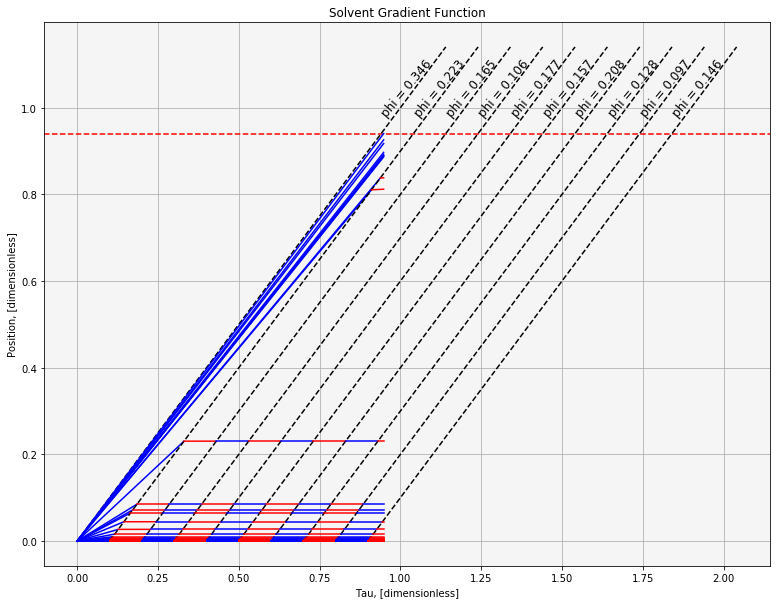

In [7]:
exp_32.print_analytes()

In [9]:
exp_32.loss()

0.7906760081180199

In [15]:
# Parameters
sigma_max = 0.3

kwargs = {
'num_episodes' : 6000,
'sample_size' : 10,
'lr' : .05,
'optim' : torch.optim.SGD,
'lr_decay_factor' : .5,
'lr_milestones' : 1000,
'print_every' : 6001,
'baseline' : 0.55,
'max_norm' : 2.
}

exp_32 = ExperimentAnalytes(k0 = alists[2].k0.values, S = alists[2].S.values, h=0.001, run_time=1.0)

pol_tau_32 = PolicySingleTime(10, sigma_max = sigma_max)

# Run Exp 32
reinforce_delta_tau(
        exp_32, 
        pol_tau_32,
        **kwargs
    )

exp_32.reset()
mu_32, _ = pol_tau_32.forward()
grads_32, delta_taus_32 = np.split(torch.cat((mu_32, tensor([1.])), 0).data.numpy(), 2)

exp_32.run_all(grads_32, delta_taus_32)


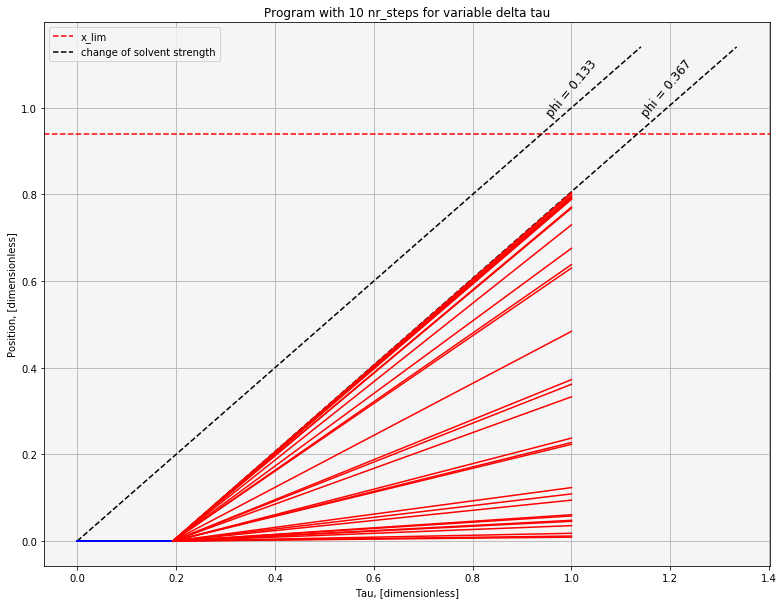

In [16]:
exp_32.print_analytes(title="Program with 10 nr_steps for variable delta tau")
plt.legend()